## Load libraries

In [1]:
import multitaper.mtspec as mtspec
import multitaper.utils as utils
import multitaper.mtcross as mtcross
import numpy as np
import matplotlib.pyplot as plt

## Load building data

In [2]:
fname = utils.data_file('crisanto_mesetas.dat')
data = np.loadtxt(fname)
dt   = 1/200.
npts,ntr = np.shape(data)

print('npts, # of traces, dt ',npts, ntr, dt)

npts, # of traces, dt  360001 5 0.005


## Plot time series

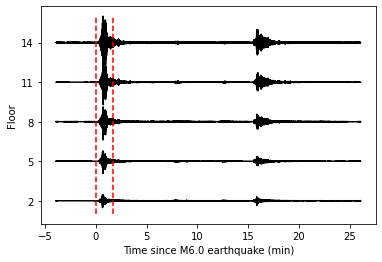

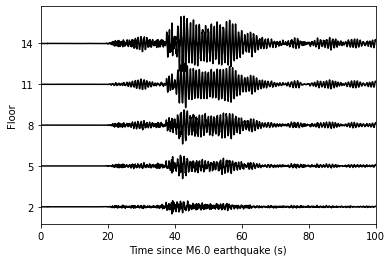

In [3]:
# create time vector
qtime = 3*60+55   # in seconds
t    = np.arange(npts)*dt - qtime
dmax = np.amax(data)/2

fig = plt.figure()
ax  = fig.add_subplot()
for i in range(ntr):
    ax.plot(t/60,data[:,i]/dmax+(i*3)+2,'k')
ax.set_xlabel('Time since M6.0 earthquake (min)')
ax.set_ylabel('Floor')
ax.set_yticks([2, 5, 8, 11, 14]);
ax.plot((0,0),(1,16),'r--')
ax.plot((1.66,1.66),(1,16),'r--')
fig = plt.figure()
ax  = fig.add_subplot()
for i in range(ntr):
    ax.plot(t,data[:,i]/dmax+(i*3)+2,'k')
ax.set_xlabel('Time since M6.0 earthquake (s)')
ax.set_xlim(0,100)
ax.set_ylabel('Floor')
ax.set_yticks([2, 5, 8, 11, 14]);
#plt.savefig('cr_spectrogram00.jpg')

In [4]:
def mt_sgram(data,dt,twin,olap=0.5,nw=3.5,kspec=5,fmin=0.0,fmax=-1.0,iadapt=0):
    """
    Function to estimate the spectrogram using the MTSPEC class repeatedly.
    User has to define the window length and optionally the overlap (def=0.5=50%)
    
    """
    
    if (fmax<=0.0):
        fmax = 0.5/dt
    
    nwin  = int(np.round(twin/dt))
    if (olap<=0.0):
        njump = nwin
    else:
        njump = int(np.round(twin*(1.0-olap))/dt)

    nmax  = npts-nwin
    nvec  = np.arange(0,nmax,njump)
    tspec = nvec*dt
    nspec = len(nvec)

    print('Window length %5.1fs and overlap %2.0f%%' %(twin, olap*100))
    print('Total number of spectral estimates', nspec)
    print('Frequency band of interest (%5.2f-%5.2f)Hz' %(fmin, fmax))

    vn,theta = utils.dpss(nwin,nw,kspec)
    for i in range(nspec):
        if ((i+1)%10==0):
            print('Loop ',i+1,' of ',nspec)

        i1  = nvec[i]
        i2  = i1+nwin
        x   = data[i1:i2+1]

        psd = mtspec.mtspec(x,nw,kspec,dt,iadapt=iadapt,
                            vn=vn,lamb=theta)

        freq2   = psd.freq
        spec    = psd.spec 
        qispec  = psd.qiinv()[0]   

        nf         = len(freq2)

        if (i==0):
            fres   = np.where((freq2>=fmin) & (freq2<=fmax))[0]
            nf     = len(fres)
            freq   = freq2[fres]
            sgram  = np.zeros((nf,nspec),dtype=float)
            sgram2 = np.zeros((nf,nspec),dtype=float)
            print('Total frequency points %i' %(nf))

        sgram[:,i]  = qispec[fres,0]
        sgram2[:,i] = spec[fres,0] 
    
    print('Finished spectrogram')
    
    return tspec,freq,sgram,sgram2

In [5]:

nw = 3.5
itrace = 4
x = data[:,itrace]
t2,freq,qisgram,mtsgram = mt_sgram(x,dt,twin=20.,olap=0.5,
                               nw=nw,kspec=5,fmin=0.05,fmax=20.)

Window length  20.0s and overlap 50%
Total number of spectral estimates 179
Frequency band of interest ( 0.05-20.00)Hz
Total frequency points 798
Loop  10  of  179
Loop  20  of  179
Loop  30  of  179
Loop  40  of  179
Loop  50  of  179
Loop  60  of  179
Loop  70  of  179
Loop  80  of  179
Loop  90  of  179
Loop  100  of  179
Loop  110  of  179
Loop  120  of  179
Loop  130  of  179
Loop  140  of  179
Loop  150  of  179
Loop  160  of  179
Loop  170  of  179
Finished spectrogram


# Plot spectrogram and time series

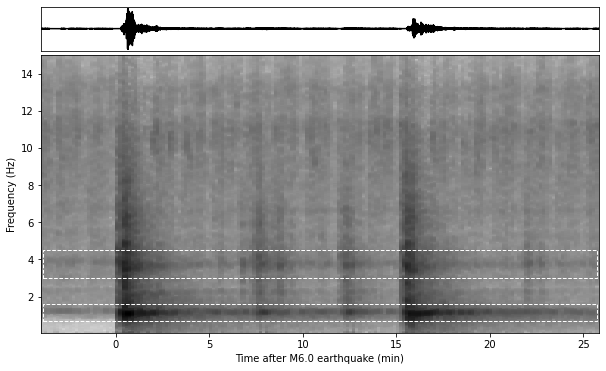

In [16]:
tspec = (t2-qtime)/60.     

df   = freq[2]-freq[1]
fnw  = nw*df
lfnw = np.array((-fnw,+fnw))

fl_1 = 3.0
fh_1 = 4.5
fl_2 = 0.7
fh_2 = 1.6

iloc1 = np.where((freq>=fl_1) & (freq<=fh_1))[0]
iloc2 = np.where((freq>=fl_2) & (freq<=fh_2))[0]

tbox  = np.array((np.min(tspec),np.max(tspec),
                 np.max(tspec),np.min(tspec),np.min(tspec)))
f2box = np.array((fl_2,fl_2,fh_2,fh_2,fl_2))
f1box = np.array((fl_1,fl_1,fh_1,fh_1,fl_1))

fig = plt.figure(figsize=(10, 6)) 
ax2 = fig.add_subplot(2,1,1)
ax2.plot(t/60,data[:,itrace]/dmax,'k')
ax2.set_xlim(np.min(tspec),np.max(tspec))
ax2.set_xticks([])
ax2.set_yticks([])
box    = ax2.get_position()
box.y0 = box.y0 + 0.24
ax2.set_position(box)

ax1 = fig.add_subplot(2,1,2)
X,Y = np.meshgrid(tspec,freq)
c = ax1.pcolor(X,Y,np.log10(qisgram),cmap='Greys', shading='auto',)
        # vmax=1e7)

ax1.plot(tbox,f2box,'w--',linewidth=1)
ax1.plot(tbox,f1box,'w--',linewidth=1)
ax1.set_xlabel('Time after M6.0 earthquake (min)')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_ylim((0.05,15))
box    = ax1.get_position()
box.y1 = box.y1 + 0.30
ax1.set_position(box)

plt.savefig('figures/tf_waveforms.jpg')

# Zoomed spectrogram

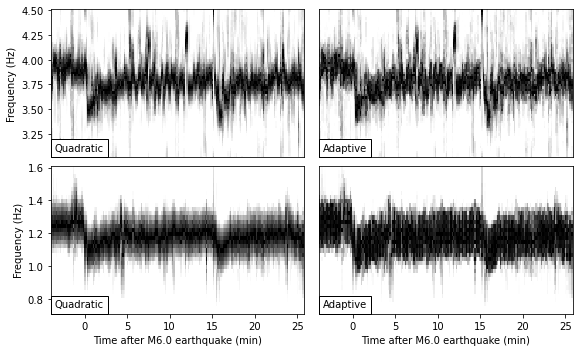

In [30]:
#------------------------------------------
# Plot spectrograms zoomed
#------------------------------------------
props = dict(facecolor='white', alpha=1.0)

f1    = freq[iloc1]
X1,Y1 = np.meshgrid(tspec,f1)
s1    = qisgram[iloc1,:]
s1b   = mtsgram[iloc1,:]
for i in range(len(tspec)):
    s1[:,i]  = s1[:,i] /np.max(s1[:,i])
    s1b[:,i] = s1b[:,i]/np.max(s1b[:,i])
f2  = freq[iloc2]
X,Y = np.meshgrid(tspec,f2)
s2  = qisgram[iloc2,:]
s2b = mtsgram[iloc2,:]
for i in range(len(tspec)):
    s2[:,i]  = s2[:,i] /np.max(s2[:,i])
    s2b[:,i] = s2b[:,i]/np.max(s2b[:,i])

fig = plt.figure(figsize=(10, 6)) 
ax1 = fig.add_subplot(2,2,1)
c = ax1.pcolor(X1,Y1,(s1),cmap='binary', shading='auto',vmin=0.1)
ax1.set_xticks([])
ax1.set_ylabel('Frequency (Hz)')
ax1.text(-3.5, 3.08, 'Quadratic',bbox=props, fontsize=10)

ax2 = fig.add_subplot(2,2,3)
c = ax2.pcolor(X,Y,(s2),cmap='binary', shading='auto',vmin=0.1)
ax2.set_ylabel('Frequency (Hz)')
ax2.set_xlabel('Time after M6.0 earthquake (min)')
ax2.text(-3.5, 0.75, 'Quadratic',bbox=props, fontsize=10)
box    = ax2.get_position()
box.y0 = box.y0 + 0.05
box.y1 = box.y1 + 0.05
ax2.set_position(box)


ax3 = fig.add_subplot(2,2,2)
c = ax3.pcolor(X1,Y1,(s1b),cmap='binary', shading='auto',vmin=0.1)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.text(-3.5, 3.08, 'Adaptive',bbox=props, fontsize=10)
box    = ax3.get_position()
box.x0 = box.x0 - 0.05
box.x1 = box.x1 - 0.05
ax3.set_position(box)

ax4 = fig.add_subplot(2,2,4)
c = ax4.pcolor(X,Y,(s2b),cmap='binary', shading='auto',vmin=0.1)
ax4.set_xlabel('Time after M6.0 earthquake (min)')
ax4.set_yticks([])
ax4.text(-3.5, 0.75, 'Adaptive',bbox=props, fontsize=10)

box    = ax4.get_position()
box.x0 = box.x0 - 0.05
box.x1 = box.x1 - 0.05
box.y0 = box.y0 + 0.05
box.y1 = box.y1 + 0.05
ax4.set_position(box)

plt.savefig('figures/tf_spec2.jpg')


# Temporal behavior of peaks


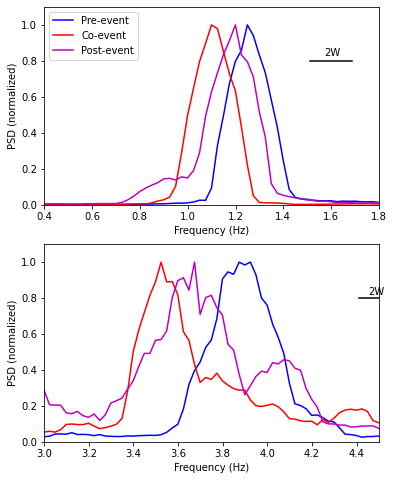

In [31]:
#------------------------------------------
# Select time windows
#------------------------------------------
k1 = 10
k2 = 28
k3 = 44

fig2 = plt.figure(figsize=(6,8))
ax2 = fig2.add_subplot(2,1,2)
ax2.plot(freq,qisgram[:,k1]/np.max(qisgram[iloc1,k1]),'b',
         label=r'time=%5.2f'%(tspec[10]));
ax2.plot(freq,qisgram[:,k2]/np.max(qisgram[iloc1,k2]),'r',
        label=r'time=%5.2f'%(tspec[28]));
ax2.plot(freq,qisgram[:,k3]/np.max(qisgram[iloc1,k3]),'m',
        label=r'time=%5.2f'%(tspec[44]));
ax2.set_xlim(fl_1,fh_1)
ax2.set_ylim(0,1.1)
ax2.plot(lfnw+4.5,[0.8,0.8],'k')
ax2.text(4.45,0.82,'2W')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('PSD (normalized)')

ax3 = fig2.add_subplot(2,1,1)
ax3.plot(freq,qisgram[:,k1]/np.max(qisgram[iloc2,k1]),'b',
         label='Pre-event');
ax3.plot(freq,qisgram[:,k2]/np.max(qisgram[iloc2,k2]),'r',
        label='Co-event');
ax3.plot(freq,qisgram[:,k3]/np.max(qisgram[iloc2,k3]),'m',
        label='Post-event');
ax3.set_xlim(0.4,fh_2+0.2)
ax3.set_ylim(0,1.1)
ax3.plot(lfnw+1.6,[0.8,0.8],'k')
ax3.text(1.57,0.83,'2W')
ax3.legend(loc='upper left')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('PSD (normalized)')
plt.savefig('figures/tf_spec1.jpg')


